In [3]:
p = 0.2


In [6]:
import numpy as np
from qiskit.circuit import QuantumCircuit

class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [7]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [8]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [9]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

In [10]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance
)

In [11]:
ae_result = ae.estimate(problem)

In [12]:
print(ae_result.estimation)

0.1464466


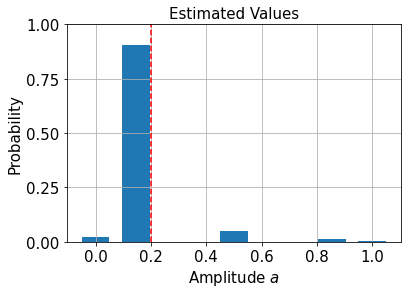

In [13]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5/len(probabilities))
plt.axvline(p, color='r', ls='--')
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.xlabel(r'Amplitude $a$', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()


In [14]:
print('Interpolated MLE estimator:', ae_result.mle)

Interpolated MLE estimator: 0.19999999390907777


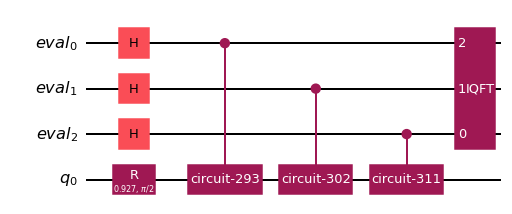

In [15]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw('mpl', style='iqx')  # decompose 1 level: exposes the Phase estimation circuit!

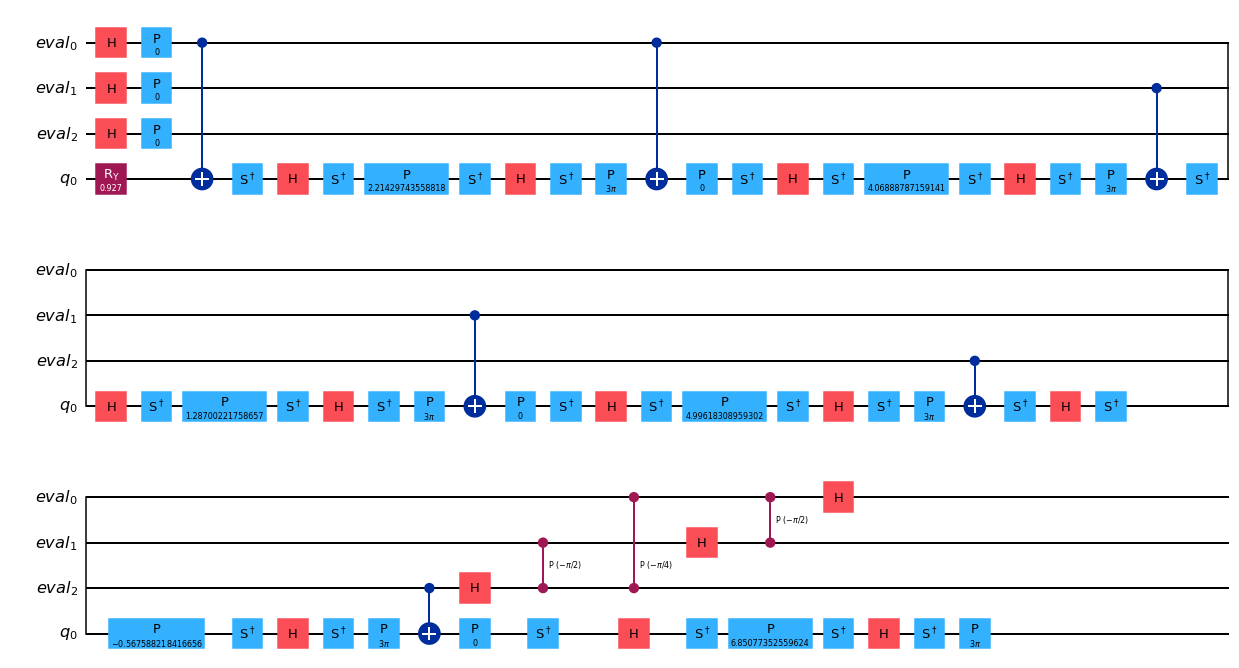

In [16]:
from qiskit import transpile


basis_gates = ['h', 'ry', 'cry', 'cx', 'ccx', 'p', 'cp', 'x', 's', 'sdg', 'y', 't', 'cz']
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw('mpl', style='iqx')

In [17]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=quantum_instance
)
iae_result = iae.estimate(problem)

print('Estimate:', iae_result.estimation)

Estimate: 0.19999999999999998


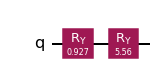

In [18]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw('mpl', style='iqx')

In [19]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    quantum_instance=quantum_instance
)
mlae_result = mlae.estimate(problem)

print('Estimate:', mlae_result.estimation)

Estimate: 0.20002237175368104


In [20]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    quantum_instance=quantum_instance
)
fae_result = fae.estimate(problem)

print('Estimate:', fae_result.estimation)

Estimate: 0.20000000000000018


/opt/conda/lib/python3.8/site-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:194: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")
